In [1]:
import pandas as pd
train_df = pd.read_csv('../usedataset/train.csv')
test_df = pd.read_csv('../usedataset/test.csv')
val_df = pd.read_csv('../usedataset/val.csv')

LSTM模型的數據準備：

分詞：將所有句子分解成單詞。
建立詞彙表：從訓練集中創建一個詞彙表，將每個唯一單詞映射到一個整數索引。
文本向量化：將每個句子轉換成整數序列，這些整數代表對應單詞的索引。
序列填充：因為LSTM模型需要固定長度的輸入，我們將使用填充來確保所有輸入序列都有相同的長度。
首先，我們需要建立詞彙表並對所有文本數據進行分詞。讓我們從計算詞彙表大小並進行文本向量化開始。

1. 使用 Tokenizer 從Keras來對文本進行分詞並建立詞彙表。
2. 將文本轉換為數字序列。
3. 使用序列填充，使所有文本數據具有相同的長度，這是神經網絡模型處理批數據的要求。

In [2]:
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer with a specific number of words
tokenizer = Tokenizer(num_words=10000)  # Limiting to top 10,000 words
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
val_sequences = tokenizer.texts_to_sequences(val_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

# Padding sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in train_sequences), 
                 max(len(seq) for seq in val_sequences), 
                 max(len(seq) for seq in test_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

max_length, train_padded.shape, val_padded.shape, test_padded.shape


(34, (16000, 34), (2000, 34), (2000, 34))

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Dropout, Embedding, LSTM
from tf_keras.utils import to_categorical
from sklearn.metrics import classification_report

# Step 2: Preparing the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['emotion'])
val_labels = label_encoder.transform(val_df['emotion'])
test_labels = label_encoder.transform(test_df['emotion'])

# Convert labels to categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

# Step 3: 建立LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=max_length, input_shape=(max_length,)),
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='sigmoid')
])

# 添加早停
from tf_keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 編譯LSTM Model
lstm_model.compile(optimizer='adam', # 使用Adam優化器，它是一種基於梯度下降的方法，能自動調整學習率，適用於大多數深度學習任務
              loss='categorical_crossentropy', 
              metrics=['accuracy'],) # 設置評估指標為準確率，即模型預測正確的比例

# Step 4: 訓練模型
history = lstm_model.fit(train_padded, train_labels, 
                    epochs=15, batch_size=64, validation_data=(val_padded, val_labels),
                    callbacks=[early_stopping])

# Step 5: 評估模型
test_loss, test_accuracy = lstm_model.evaluate(test_padded, test_labels)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# 輸出分類報告
y_pred_prob = lstm_model.predict(test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Epoch 1/15
250/250 [==============================] - 6s 18ms/step - loss: 1.5690 - accuracy: 0.3444 - val_loss: 1.3634 - val_accuracy: 0.4740
Epoch 2/15
250/250 [==============================] - 3s 13ms/step - loss: 0.9913 - accuracy: 0.6317 - val_loss: 0.7502 - val_accuracy: 0.7555
Epoch 3/15
250/250 [==============================] - 3s 13ms/step - loss: 0.6618 - accuracy: 0.7595 - val_loss: 0.6603 - val_accuracy: 0.7765
Epoch 4/15
250/250 [==============================] - 3s 14ms/step - loss: 0.5176 - accuracy: 0.8171 - val_loss: 0.5469 - val_accuracy: 0.8245
Epoch 5/15
250/250 [==============================] - 3s 13ms/step - loss: 0.3969 - accuracy: 0.8660 - val_loss: 0.4787 - val_accuracy: 0.8465
Epoch 6/15
250/250 [==============================] - 3s 13ms/step - loss: 0.3195 - accuracy: 0.8918 - val_loss: 0.4194 - val_accuracy: 0.8710
Epoch 7/15
250/250 [==============================] - 3s 13ms/step - loss: 0.2714 - accuracy: 0.9097 - val_loss: 0.3769 - val_accuracy: 0.8855

In [4]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 34)            340000    
                                                                 
 lstm (LSTM)                 (None, 32)                8576      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 349206 (1.33 MB)
Trainable params: 349206 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


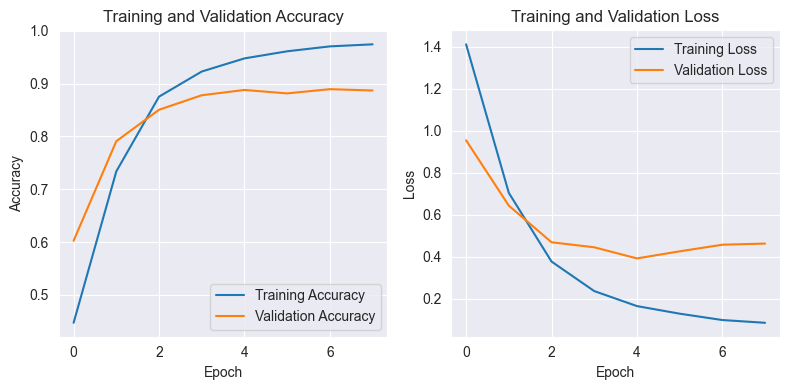

In [5]:
import matplotlib.pyplot as plt
# 繪製訓練和驗證的準確度
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 繪製訓練和驗證的損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()